# Using boostwrap for regression

In [1]:
# This is a hack to make graphviz work with the conda environment. Maybe you do not need it.
import os, sys
os.environ["PATH"] = os.path.dirname(sys.executable) + os.pathsep + os.environ["PATH"]

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import model_selection

In [3]:
%matplotlib notebook

In [4]:
# Silencing some warning from scikit learn an numpy
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)

In [5]:
from boostwrap import Regressor

## Example data preparation

In [6]:
def construct_analysis_table(tumor_type, my_cluster, path_to_table, covariates, response):
    raw_table = pd.read_csv(path_to_table, sep='\t')
    raw_table = raw_table[raw_table[tumor_type + '_' + my_cluster + '_' + 'mutations'] != 0]
    table = raw_table[covariates].copy()
    exp = '_'.join([tumor_type, my_cluster, 'expected_muts'])
    obs = '_'.join([tumor_type, my_cluster, 'mutations'])
    table[response] = (raw_table[obs] - raw_table[exp]) / raw_table[exp] 
    return table

In [7]:
tumor_type = 'crc'    # options: 'crc', 'bMMRD'
cluster = 'clusterA'  # options: 'clusterA', 'clusterB'
curr_chunk = '100kb'  # options: '1Mb', '100kb', '10000bp'
PATH_DATA = '/workspace/projects/genomewide_MMR/data/'
path_to_table = os.path.join(PATH_DATA, curr_chunk + '_segments_data_v8.txt')
covariates = ['E075_H3K27ac_covered_bp', 'E075_H3K27me3_covered_bp', 'E075_H3K36me3_covered_bp']
response = 'rel_diff' + '_' + tumor_type + '_' + cluster + '_mutations'
table = construct_analysis_table(tumor_type, cluster, path_to_table, covariates, response)

## Regression

In [8]:
import pickle

mypickle = '/workspace/projects/genomewide_MMR/results/feature_importance/crc_clusterA_100kb_rel_diff_crc_clusterA_mutations.pickle'

with open(mypickle, 'rb') as f:
    outcome = pickle.load(f)
params = outcome['params']
params['n_estimators'] = 100

In [9]:
myregressor = Regressor(**params)

x_data = table[covariates]
y_data = table[response]
myregressor.train(x_data, y_data)

In [10]:
myregressor.get_mutual_information(x_data, y_data)

{'E075_H3K36me3_covered_bp': 1,
 'E075_H3K27ac_covered_bp': 2,
 'E075_H3K27me3_covered_bp': 3}

In [11]:
importance = myregressor.get_importance(method='mse')
print('Cover: ', importance['cover'].importance)
print('Gain: ', importance['gain'].importance)
print('Permutation: ', importance['permutation'].importance)

Cover:  {'E075_H3K27ac_covered_bp': 11932.662983425414, 'E075_H3K36me3_covered_bp': 9809.420454545454, 'E075_H3K27me3_covered_bp': 11417.888}
Gain:  {'E075_H3K27ac_covered_bp': 77.07399056469613, 'E075_H3K36me3_covered_bp': 79.69742445522728, 'E075_H3K27me3_covered_bp': 18.206550028871998}
Permutation:  {'E075_H3K27ac_covered_bp': -0.04058020214746763, 'E075_H3K27me3_covered_bp': -0.005693090803216533, 'E075_H3K36me3_covered_bp': -0.041718255937087334}


<IPython.core.display.Javascript object>


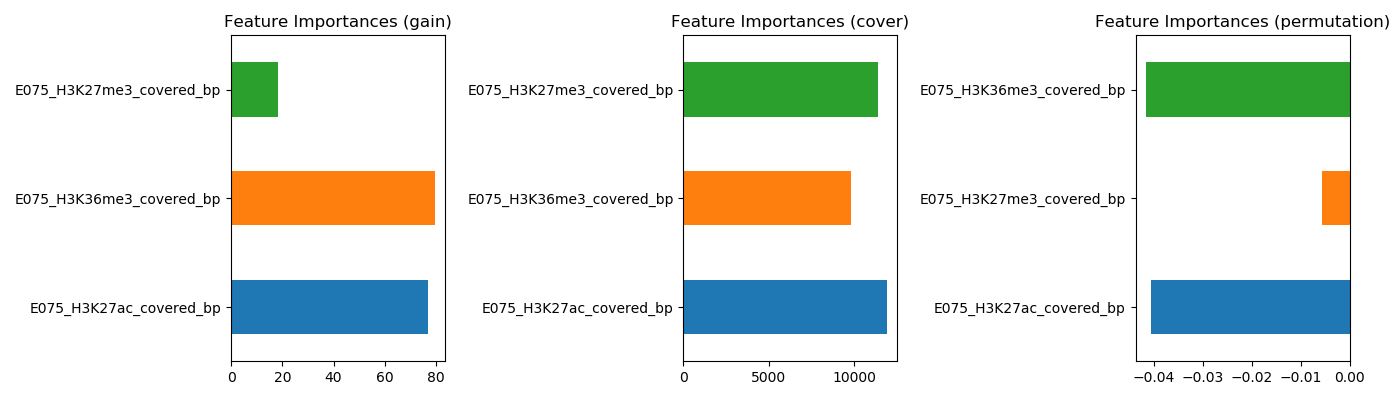

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
importance['gain'].plot(axes[0], std=False)
importance['cover'].plot(axes[1], std=False)
importance['permutation'].plot(axes[2], std=False)
plt.show()

In [13]:
myregressor.get_importance(method='r2')

{'cover': <boostwrap.methods.FeatureImportance at 0x7f38e92ba160>,
 'gain': <boostwrap.methods.FeatureImportance at 0x7f38e92d11d0>,
 'permutation': <boostwrap.methods.FeatureImportance at 0x7f3903c52908>}

In [14]:
myregressor.get_mutual_information(x_data, y_data)

{'E075_H3K36me3_covered_bp': 1,
 'E075_H3K27ac_covered_bp': 2,
 'E075_H3K27me3_covered_bp': 3}

In [15]:
myregressor.predict(x_data)

array([ 0.1841931 ,  0.3398353 , -0.11903059, ..., -0.27304918,
       -0.28656983, -0.2571571 ], dtype=float32)

In [16]:
x = myregressor.x_data.copy()
x['E075_H3K27ac_covered_bp'].values

array([    0,     0,  3799, ..., 27146, 14809,  5192])

In [17]:
x_data.values

array([[    0,     0,   664],
       [    0,     0,     0],
       [ 3799,   726,  1962],
       ...,
       [27146,  7292,  4865],
       [14809, 10485,  5674],
       [ 5192,  7697, 11389]])

<IPython.core.display.Javascript object>


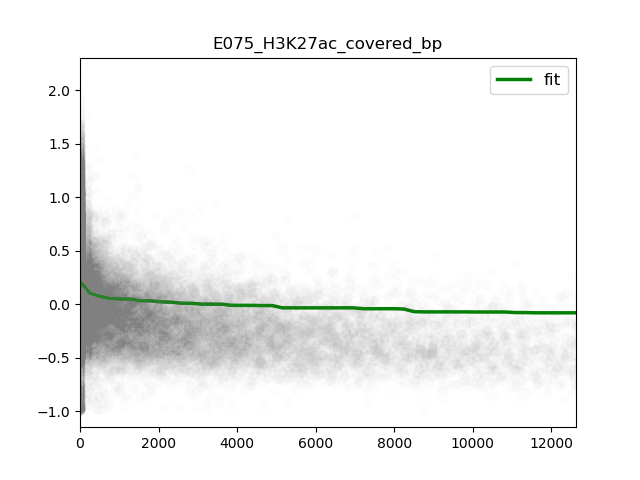

<IPython.core.display.Javascript object>


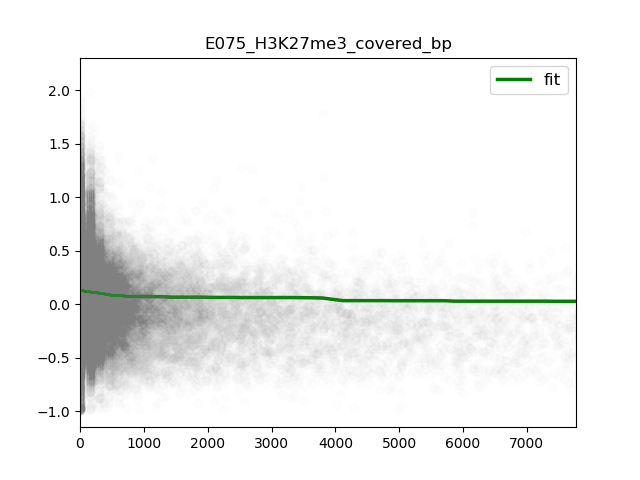

<IPython.core.display.Javascript object>


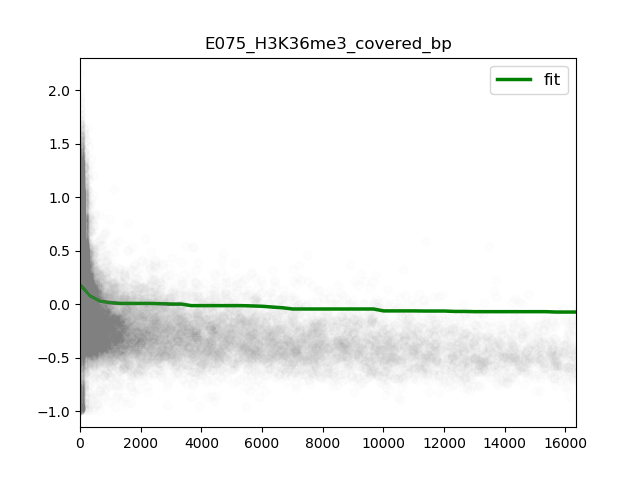

In [18]:
partial_dependencies = myregressor.get_partial_dependence(covariates)

for feat, dependence in partial_dependencies.items():
    fig, axes = plt.subplots()
    dependence.plot(axes, linewidth=2.5)
    axes.plot(x_data[feat].values, y_data.values, 'o', color='grey', alpha=0.01)
    plt.show()

## Evaluation

In [19]:
myregressor.score(x_data, y_data, method='variance')

0.4106995460198666

In [20]:
myregressor.score(x_data, y_data, method='r2')

0.37764497941892605

In [21]:
myregressor.score(x_data, y_data, method='mse')

0.12371748763566259

<IPython.core.display.Javascript object>


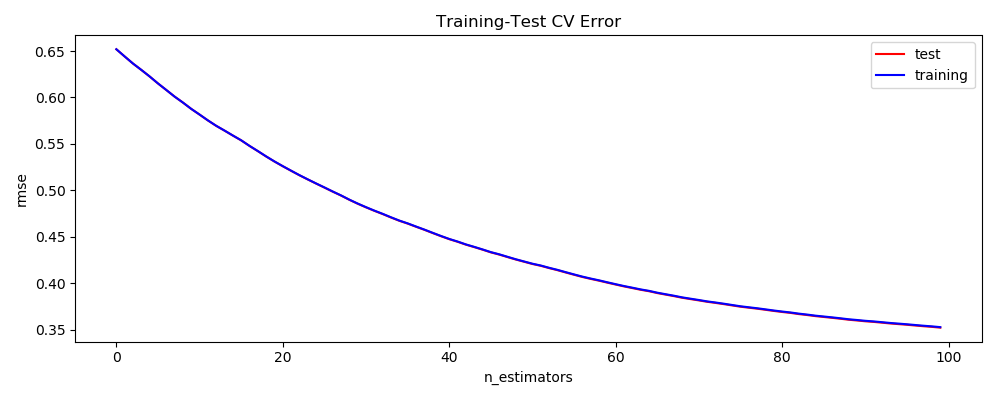

In [22]:
cv = myregressor.cv()

fig, axes = plt.subplots(figsize=(10,4))
cv.plot(axes)
plt.show()

<IPython.core.display.Javascript object>


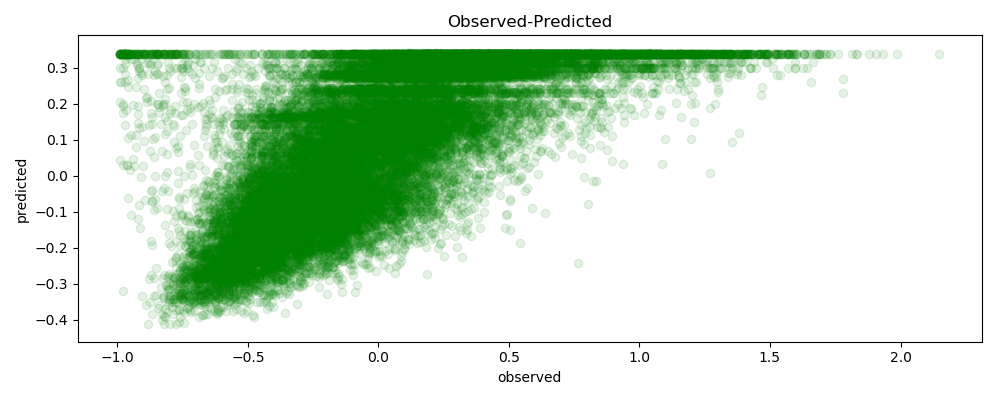

In [23]:
fig, axes = plt.subplots(figsize=(10,4))
myregressor.plot_scatter(axes, alpha=0.1)
plt.show()

<IPython.core.display.Javascript object>


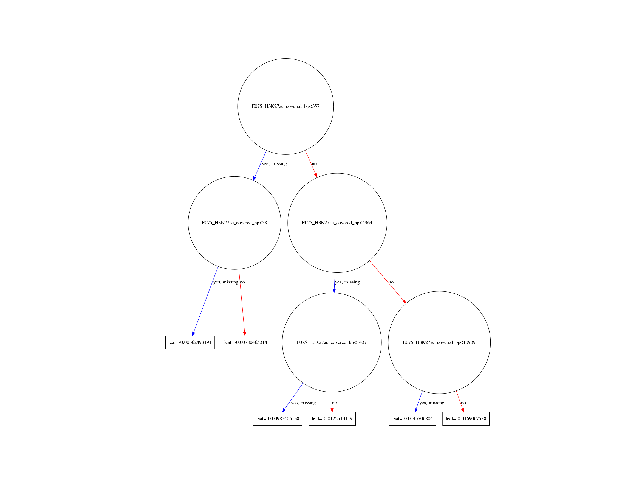

In [24]:
fig, axes = plt.subplots()
myregressor.plot_example_tree(axes)
plt.show()